In [1]:
import numpy as np
import pandas as pd
import urllib.request
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc,roc_auc_score,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from tqdm.auto import tqdm
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt

In [2]:
!pip install tqdm

In [3]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv'
urllib.request.urlretrieve(url,'AER_credit_card_data.csv')

('AER_credit_card_data.csv', <http.client.HTTPMessage at 0x1d87845ef40>)

In [4]:
df = pd.read_csv('AER_credit_card_data.csv')

In [5]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [6]:
df.columns = df.columns.str.lower().str.replace(' ','_')
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
for c in categorical_columns:
    df[c] =df[c].str.lower().str.replace(' ','_')

In [7]:
categorical_columns

['card', 'owner', 'selfemp']

In [8]:
df.dtypes

card            object
reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
dtype: object

In [9]:
df.isnull().sum()

card           0
reports        0
age            0
income         0
share          0
expenditure    0
owner          0
selfemp        0
dependents     0
months         0
majorcards     0
active         0
dtype: int64

In [10]:
df = df.copy()

In [11]:
target = (df.card =="yes").astype(int)
target
target.name ='target'

In [12]:
df =df.join(target)

In [13]:
df_full_train,df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=1,
)
df_train,df_val = train_test_split(
    df_full_train,
    test_size=0.25,
    random_state=1,
)

In [14]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [15]:
y_train = df_train.target.values
y_val = df_val.target.values
y_test = df_test.target.values

In [16]:
del df_train['target']
del df_val['target']
del df_test['target']

In [17]:
df_train

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,no,3,40.50000,4.0128,0.000299,0.00000,no,no,1,12,1,17
1,no,1,32.33333,6.0000,0.000200,0.00000,yes,no,4,18,1,4
2,yes,1,29.16667,2.2000,0.038205,69.79333,no,no,0,49,1,7
3,yes,1,54.66667,7.2900,0.106536,647.20670,yes,no,2,78,1,9
4,yes,0,25.00000,3.3984,0.000353,0.00000,yes,no,2,29,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
786,yes,0,53.00000,2.4500,0.017718,35.67500,yes,no,0,3,1,11
787,no,2,30.58333,2.5000,0.000480,0.00000,no,no,0,12,1,18
788,yes,0,24.75000,1.8750,0.080708,126.02250,no,no,1,14,0,1
789,yes,1,56.91667,3.4838,0.062895,182.09580,yes,no,0,540,1,7


In [18]:
#question1
df.dtypes

card            object
reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
target           int32
dtype: object

In [19]:
#Question1
list = ['reports','dependents','active','share']
features = df[list]
features
scores = []
for i in features.columns:
    fpr, tpr, thresholds = roc_curve((df_train['card'].values =="yes").astype(int),df_train[i].values, pos_label = 1)
    aucval = auc(fpr, tpr)
    if aucval < 0.5:
        fpr, tpr, thresholds = roc_curve((df_train['card'].values =="yes").astype(int),-1*(df_train[i].values), pos_label = 1)
        aucval = auc(fpr, tpr)
        
    scores.append(f"score of {i} = {aucval}")
print(scores)
#AUC goes below 0.5 if the variable is negatively correlated with the target variable.

['score of reports = 0.7166629860689376', 'score of dependents = 0.5327757227773791', 'score of active = 0.6043173411362006', 'score of share = 0.989183643423692']


In [20]:
df.dtypes

card            object
reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
target           int32
dtype: object

In [21]:
categorical = ["owner", "selfemp"]
numerical = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active"]


In [22]:
#Question3
def train(df_train,y_train,C=1.0):
    dicts = df_train[categorical+numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    model = LogisticRegression(solver='liblinear',C=C,max_iter = 1000)
    #C is inverse of regularization parameter, the smaller the C the better the regularization
    model.fit(X_train,y_train)
    return dv,model

In [23]:
dv,model = train(df_train,y_train,C=1.0)

In [24]:
def predict(df_val,dv,model):
    dicts = df_val[categorical+numerical].to_dict(orient='records')
    X =dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]
    return y_pred

In [25]:
y_pred = predict(df_val,dv,model)

In [26]:
y_pred.shape,y_val.shape,df_val.shape

((264,), (264,), (264, 12))

In [27]:
fpr,tpr,thresholds = roc_curve(y_val,y_pred)

In [28]:
#Question 2
auc(fpr,tpr).round(3)

0.995

In [29]:
#question 3

In [30]:
t = np.arange(0,1.01,0.01)
recall = []
precision = []
F1 = []
for i in t:
    predict_positive = (y_pred >= i)
    predict_negative = (y_pred < i)
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    precision_val = tp/(tp+fp)
    recall_val = tp/(tp+fn)
    precision.append(precision_val)
    recall.append(recall_val)
    F1.append(2*(precision_val*recall_val)/(precision_val+recall_val))
    


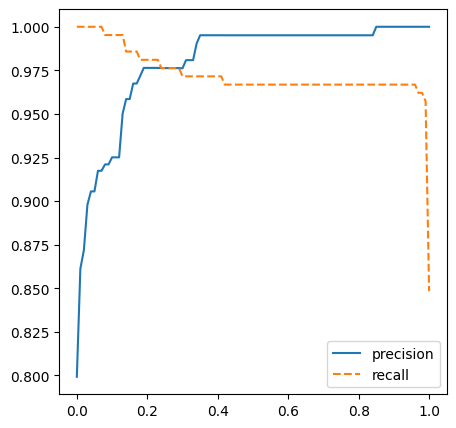

In [31]:
#question 3
plt.figure(figsize=(5,5))
plt.plot(t,precision,label='precision')
plt.plot(t,recall,label='recall',linestyle='--')
plt.legend()

In [32]:
i = np.arange(0,1,0.01)
for t in range (0,100):
    print(f"for treshold {i[t]} = {F1[t]}")

for treshold 0.0 = 0.8884210526315789
for treshold 0.01 = 0.9254385964912281
for treshold 0.02 = 0.9315673289183224
for treshold 0.03 = 0.946188340807175
for treshold 0.04 = 0.9504504504504505
for treshold 0.05 = 0.9504504504504505
for treshold 0.06 = 0.9569160997732427
for treshold 0.07 = 0.9569160997732427
for treshold 0.08 = 0.9567198177676538
for treshold 0.09 = 0.9567198177676538
for treshold 0.1 = 0.958904109589041
for treshold 0.11 = 0.958904109589041
for treshold 0.12 = 0.958904109589041
for treshold 0.13 = 0.9722222222222221
for treshold 0.14 = 0.9719626168224299
for treshold 0.15 = 0.9719626168224299
for treshold 0.16 = 0.9765258215962441
for treshold 0.17 = 0.9765258215962441
for treshold 0.18 = 0.9764150943396227
for treshold 0.19 = 0.9787234042553191
for treshold 0.2 = 0.9787234042553191
for treshold 0.21 = 0.9787234042553191
for treshold 0.22 = 0.9787234042553191
for treshold 0.23 = 0.9787234042553191
for treshold 0.24 = 0.976303317535545
for treshold 0.25 = 0.97630331753

In [33]:
#Question 4


In [34]:
i = [0.1,0.4,0.6,0.7]
for t in range (0,4):
    print(f"for treshold {i[t]} = {F1[t]}")

for treshold 0.1 = 0.8884210526315789
for treshold 0.4 = 0.9254385964912281
for treshold 0.6 = 0.9315673289183224
for treshold 0.7 = 0.946188340807175


In [35]:
#Question5

In [36]:
kfold = KFold(n_splits=5,shuffle=True,random_state=1)

In [37]:
train_idx,val_idx = next(kfold.split(df_full_train))
train_idx.shape,val_idx.shape

((844,), (211,))

In [38]:
len(df_full_train)

1055

In [39]:
df_train = df_full_train.iloc[train_idx]
y_train = df_full_train.iloc[train_idx].target.values
df_val = df_full_train.iloc[val_idx]
y_val = df_val.target.values

In [40]:
len(train_idx),len(val_idx),len(df_val),len(val_idx),len(y_val)

(844, 211, 211, 211, 211)

In [45]:
scores=[]
for train_idx,val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.card.values
    y_values = df_val.card.values

    dv,model = train(df_train,y_train)
    y_pred = predict(df_val,dv,model)
    auc = roc_auc_score(y_val,y_pred)
    scores.append(auc)

stand_dev = np.std(scores).round(3)
print(f"standard deviation is : {stand_dev}")

standard deviation is : 0.209


In [50]:
#Checking progress of each iteration using tqdm
n_splits = 5
for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=5,shuffle=True,random_state=1)
    
    scores = []
    for train_idx,val_idx in \
        tqdm(kfold.split(df_full_train),total=n_splits):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.card.values
        y_val = df_val.card.values

        dv,model = train(df_train,y_train,C=C)
        y_pred = predict(df_val,dv,model)
        auc = roc_auc_score(y_val,y_pred)
        scores.append(auc)
    print('C=%s %.3f += %.3f' % (C,np.mean(scores), np.std(scores)))
    
np.mean(scores), np.std(scores)

#cross validation --> take higher k values for smaller models , i.e split into ,ore chunks
# cross validation helps understand std that gives the stability of model across different data chunks


#Training the model now in full train dataset with the best C value.
dv,model = train(df_full_train,df_full_train.card.values,C=1.0)
y_pred = predict(df_val,model)
auc = roc_auc_score(y_val,y_pred)
auc
# 

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

C=0.01 0.992 += 0.006


  0%|          | 0/5 [00:00<?, ?it/s]

C=0.1 0.995 += 0.004


  0%|          | 0/5 [00:00<?, ?it/s]

C=1 0.996 += 0.003


  0%|          | 0/5 [00:00<?, ?it/s]

C=10 0.996 += 0.003


TypeError: predict() missing 1 required positional argument: 'model'

In [54]:
dv,model = train(df_full_train,df_full_train.target.values,C=1)
y_pred = predict(df_test,dv,model)
auc = roc_auc_score(y_test,y_pred)
auc

0.996097337006428